<a href="https://colab.research.google.com/github/thainehassumpcao/u-net-reproduction/blob/master/Deep_Learning_Reproduction_U_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **U-Net Reproduction**

In biomedical image processing, the development of the [u-net](https://arxiv.org/abs/1505.04597) allowed for  varied tasks to be performed without large datasets. Published in 2015, the study included state-of-the art results, ranking among the best in the [EM segmentation challenge](http://brainiac2.mit.edu/isbi_challenge/) started at ISBI in 2012 and the segmentation task part of the [ISBI cell tracking challenge](http://celltrackingchallenge.net/) 2014 and 2015. This paper is cited more than 13k times and follow-up works (in [3D images](https://arxiv.org/abs/1606.06650) and [extending to multiple cases](https://www.nature.com/articles/s41592-018-0261-2)) continued pushing high scores and providing a more generalized tool for biomedical tasks.

In this notebook, we present our replication of the network and of some of its results. We went for full independent replication, based only on the paper's content. We tried to get more information the follow-up papers but they were mostly not useful. Also, we tried to get at least the hyperparameters from their caffe implementation and we emailed the authors, but no luck.


---
 **What is u-net's goal?**

Its main purpose is to segment biomedical images into two or more classes. The net is applied to three segmentation tasks:

*   Neuronal structures in electrom microscopic recordings (Experiment 1)
*   Lightmicroscopic images of:
    *   Glioblastoma-astrocytoma U373 cells (Experiment 2)
    *   HeLa cells (Experiment 3)

---
**What did we do?**

We replicated Experiment 1, in which we classify the incoming image into two classes: cell (white) and membrane (black):

![alt text](http://brainiac2.mit.edu/isbi_challenge/sites/default/files/Challenge-ISBI-2012-Animation-Input-Labels.gif)
[GIF source](http://brainiac2.mit.edu/isbi_challenge/sites/default/files/Challenge-ISBI-2012-Animation-Input-Labels.gif/) 

In the following notebook cells, we explain in details u-net, what we did and the results we got to.











# Setting the scene


**Imports**

Other than the commonly used libraries, we install the `elasticdeform`, used for data augmentation and `tifffile` to be able to save a 3D `.tiff` file with predictions.

In [1]:
!pip install elasticdeform
!pip install tifffile
import time
import os
import random
import elasticdeform
import tifffile
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.utils as utils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from torchsummary import summary
from pathlib import Path
from PIL import Image
from sklearn import model_selection
from google.colab import drive

  Created wheel for elasticdeform: filename=elasticdeform-0.4.6-cp36-cp36m-linux_x86_64.whl size=70444 sha256=5018c0e496ea422741afedcde581aba696ba7f67e73973aa771eb1698dc73797
  Stored in directory: /root/.cache/pip/wheels/42/3a/94/a1d69f8b9da44826a171395e67f9f7a117f89af18f206481dd
Successfully built elasticdeform
     |████████████████████████████████| 133kB 3.4MB/s 
     |████████████████████████████████| 18.1MB 171kB/s 


**Setup directory (colab or locally)**

To run the program locally, please download the data sets, add a case to this function and call set_dir('new_name'). 

In [2]:
def set_dir(case):
    dir = ''
    if case == 'colab':
        drive.mount('/content/drive', force_remount=True)
        dir = r'/content/drive/My Drive/Reproducibility/U-Net'
    elif case == 'django':
        dir = r'C:/Users/Django/Documents/TU Delft/Master/Year 1/Q3/Deep Learning - CS4240/Reproducibilty Project/U-Net'
    elif case == 'thaine':
        dir = r'C:/Users/herma11/Deep_learning/Reproducibility/U-Net'
    os.chdir(dir)


set_dir('colab')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# **Loading Data**

We loaded data from the three experiments, in case we had time to run all three. We didn't, but please feel welcome to use it and test it further!

**Load data from Experiment 1**

Similarly to the paper, the data was obtained through the EM segmentation challenge website. They were divided in three multi-tiff files:

*   train-volume: 30 input images. Mode: gray-scale. Dimensions: 512x512
*   train-targets: 30 (corresponding) target images. Mode: gray-scale. Dimensions: 512x512
*   test-volume: 30 input images. Mode: gray-scale. Dimensions: 512x512

The targets for the test data are not provided, thus we split the training dataset into training and evaluation sets (60/40 split).

Further, u-net's output is smaller than the input, because there is no padding in the convolutions. In unet's example architecture, the input is 572x572 and the output is 388x388. Therefore, the output only contains the information located in the center of the input. We chose to keep the output information content as close to the target as possible, so we used as input 700x700 (by padding with reflection) and got 516x516 as output. 

To allow for different choices, we set these dimensions as hyperparameters.In the loading function the evaluation and testing images are transformed according to `dim` ([dim_input, dim_target]). The training and target images are transformed when passing through data augmentation.

In [0]:
def load_dataset_1(dim, train=True, eval=True, test=True):
    """
        Load Dataset from the first experiment.
    """
    data_dir = Path('Data Set/EM Segmentation Challenge')

    # Initialize entries for storing respective data sets
    SEG_train_loader, SEG_eval_loader, SEG_test_loader = [], [], []

    # Use the following files to load the appropriate data
    input_img = Image.open(data_dir / 'train-volume.tif')
    target_img = Image.open(data_dir / 'train-labels.tif')
    test_img = Image.open(data_dir / 'test-volume.tif')

    # Load train (and evaluation) images
    if train:    

        if eval:            
            # Decide which image to place in train/eval
            train_list, _ = model_selection.train_test_split(
                                                    range(input_img.n_frames), 
                                                    train_size=0.6, 
                                                    test_size=0.4)
                  
        # Load input images and target labels
        for i in range(input_img.n_frames):
            # Because the data is loaded one-by-one we use .seek(i) to select the appropriate image     
            input_img.seek(i)
            target_img.seek(i)

            if eval:
                # Based on the split made above, we decide in which set to place the input-target pair.
                if i in train_list:
                    SEG_train_loader.append((transforms.ToTensor()(input_img),
                                            transforms.ToTensor()(target_img)
                                            ))              
                else:
                    SEG_eval_loader.append((transforms.ToTensor()(input_img),
                                            transforms.ToTensor()(target_img)
                                            ))
            else:
                SEG_train_loader.append((transforms.ToTensor()(input_img),
                                        transforms.ToTensor()(target_img)
                                        ))
    
    # Load the test images
    if test:
        for i in range(test_img.n_frames):
            test_img.seek(i)
            test_size = test_img.size[0]
            pad = int((dim[0]-test_size)/2)
            test = transforms.Compose([
                                    transforms.Pad(padding=pad, padding_mode='reflect'),
                                    transforms.ToTensor()
                                    ])(test_img)
            SEG_test_loader.append((test, None))

    return SEG_train_loader, SEG_eval_loader, SEG_test_loader

**Load data from Experiment 2** 

In [0]:
def load_dataset_2():
    # Initialize loader for the training data and ground truth data
    data_dir = r'Data Set\EM Cell Tracking Challenge/PhC-C2DH-U373'
    PhC_train_loader = []

    # Get training data, coming from the frames of two videos
    videos = ['01', '02']
    for video in videos:
        truth_path = Path(os.path.join(data_dir, r'{}_GT/SEG'.format(video)))
        # Iterate through the ground truth segmented images because not all frames were trained
        for child in truth_path.iterdir():
            target = Image.open(child)
            timestamp = (child.stem[-3:])
            input_path = Path(os.path.join(data_dir, '{}/t{}.tif'.format(video, timestamp)))
            input = Image.open(input_path)

            input = transforms.ToTensor()(input)
            target = transforms.ToTensor()(target)
            PhC_train_loader.append((input, target))
    return PhC_train_loader

**Load data from Experiment 3**

In [0]:
def load_dataset_3():
    # Initialize loader for the training data and ground truth data
    data_dir = r'Data Set\EM Cell Tracking Challenge/DIC-C2DH-HeLa'
    HeLa_train_loader = []

    # Get training data, coming from the frames of two videos
    videos = ['01', '02']
    for video in videos:
        truth_path = Path(os.path.join(data_dir, r'{}_GT/SEG'.format(video)))
        for child in truth_path.iterdir():
            target = Image.open(child)
            timestamp = (child.stem[-3:])
            input_path = Path(os.path.join(data_dir, '{}/t{}.tif'.format(video, timestamp)))
            input = Image.open(input_path)
            input = transforms.Resize(572)(input)
            input = transforms.ToTensor()(input)
            input = transforms.Normalize(mean=[0.4], std=[0.229])(input)
            target = transforms.CenterCrop(388)(target) # temporary, because the output will be 388 instead of 572
            target = transforms.ToTensor()(target)
            HeLa_train_loader.append((input, target))
    return HeLa_train_loader

 **Show Dataset**
 
By looking at the dataset, we noticed that the membranes are quite thin and that the very obvious 'black circles' (probably the cell center) should be classified as cell. Therefore in a qualitative evaluation of results we look for those differences.

Training images - unprocessed


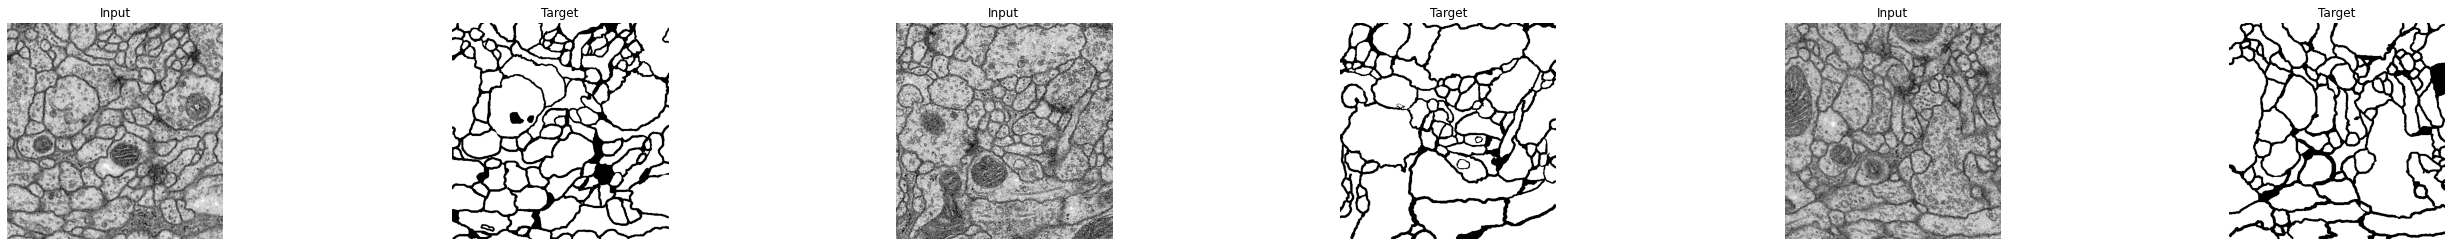

Test images - processed


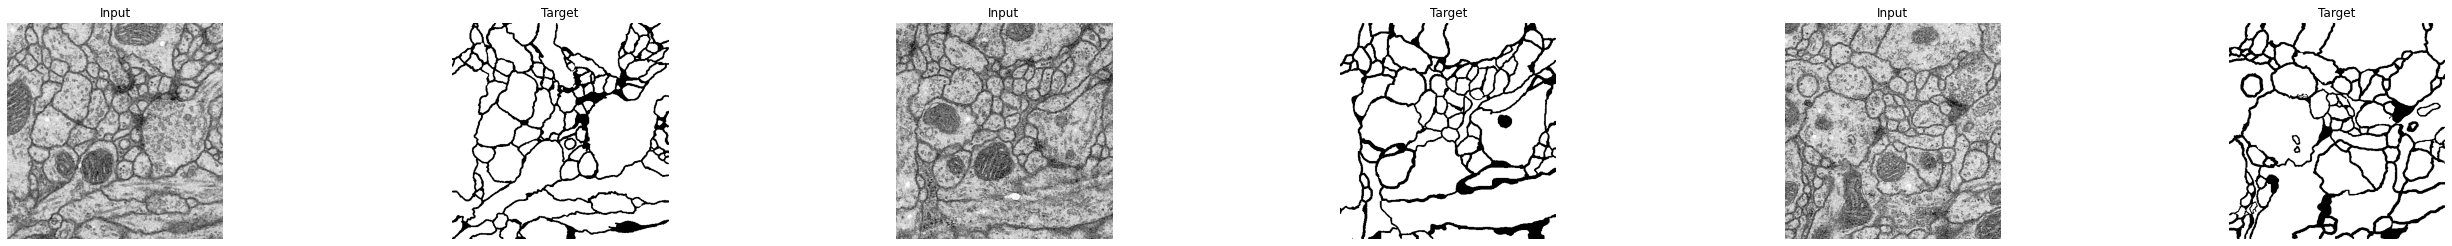

In [6]:
def show_dataset(dataset, grayscale=True):
    """
        This function allows one to check if the data is loaded correctly. It will display three random samples form the set.
    """
    if grayscale:
        cmap = 'Greys_r'
    else:
        cmap = None

    plt.figure(figsize=(40, 3))
    for i in range(1, 6, 2):
        rand_idx = random.randrange(len(dataset))
        for j in range(0, 2):
            plt.subplot(1, 6, i + j)
            tensor = dataset[rand_idx][j].squeeze()
            plt.imshow(tensor, cmap=cmap, aspect='equal')
            plt.subplots_adjust(top=1, bottom=0, left=0.05, right=0.95)
            plt.axis('off')
            if j==0:
                plt.title('Input')
            else:
                 plt.title('Target')
    plt.show()

SEG_train_loader, SEG_test_loader, _ = load_dataset_1([700,516])
print('Training images - unprocessed')
show_dataset(SEG_train_loader)
print('Test images - processed')
show_dataset(SEG_test_loader)

# **Data Augmentation**

As seen, the dataset is extremely small (30 images only!!) and consequently, the authors did extensive data augmentation. They don't mention how much, so we performed 5 augmentations per image and treated augmentation as a hyperparameter. 

The process we took to augment an image is:

* Mirror (reflect) the image borders
    * To arrive to the final size
    * Enough to fill future empty areas due to transformations
* Rotate
    * Randomly between 0 and 360 degrees (according to a follow-up paper)
* Perform elastic deformation
* Crop to the final size 
(removing as much reflected information as possible)

Training image


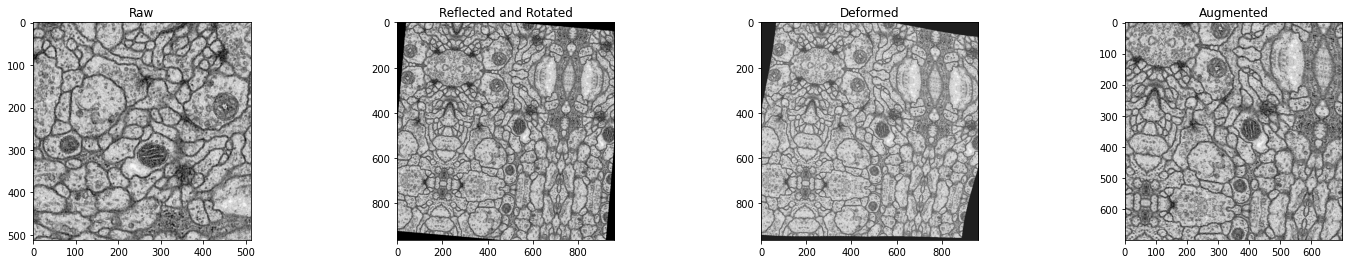

Target image


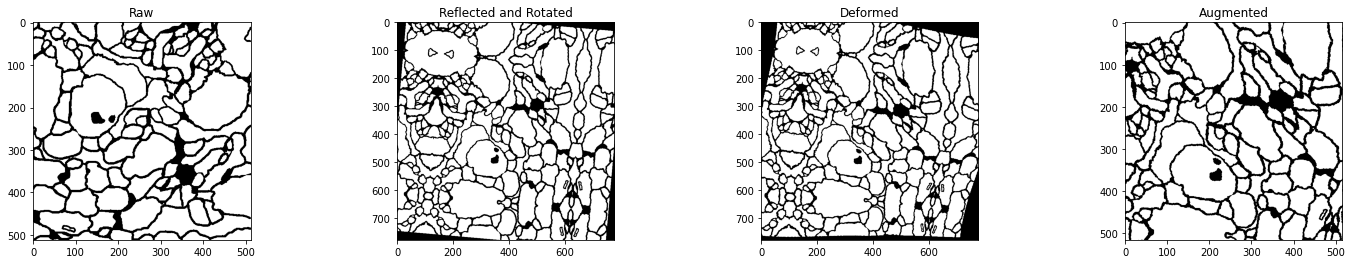

In [7]:
def generate_aug_image(seed, tensor, final_size, target=False, plot=False):
    """ 
    Create one augmented image by rotation and elastic deformation
    """

    random.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)

    # Padding to put the image in the final size
    original_size = tensor.size(1)
    pad = int((final_size - original_size)/2)

    #Padding to handle transformations
    pad += int((np.sqrt(2*(original_size**2)) - original_size)/2) + 25

    rotated_tensor  = transforms.Compose([
                        transforms.ToPILImage(),
                        transforms.Pad(padding=pad, padding_mode='reflect'),
                        transforms.RandomRotation(degrees=(0, 360), fill=(0,)),
                        transforms.ToTensor()
    ])(tensor)

    # Pytorch does not support elastic transformations, thus it is done outside compose
    rotated_tensor = rotated_tensor.squeeze()
    deformed_array = elasticdeform.deform_random_grid(rotated_tensor.numpy(), sigma=25, points=3)
    # The elastic deformation results in a non-binary image, so thresholding is necessary
    if target:
        deformed_array[deformed_array <= 0.5] = 0
        deformed_array[deformed_array > 0.5] = 1

    new_tensor = transforms.Compose([
                                transforms.ToPILImage(),
                                transforms.CenterCrop(final_size),
                                transforms.ToTensor()
    ])(deformed_array)

    if plot:
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(figsize=(25, 4), ncols=4)
        f1 = ax1.imshow(tensor, cmap='Greys_r')   
        f2 = ax2.imshow(rotated_tensor, cmap='Greys_r')
        f3 = ax3.imshow(deformed_array, cmap='Greys_r')
        f4 = ax4.imshow(new_tensor.squeeze(), cmap='Greys_r')  
        ax1.set_title('Raw')
        ax2.set_title('Reflected and Rotated')
        ax3.set_title('Deformed')
        ax4.set_title('Augmented')
        plt.show()

    return new_tensor


def data_augmentation(train_loader, dim, augment=5, plot=False):

    train_augmented = []
    for i, (input, target) in enumerate(train_loader):

        # Save original images
        original_size = input.size(1)
        pad = int((dim[0] - original_size)/2)
        input = transforms.Compose([
                                    transforms.ToPILImage(),
                                    transforms.Pad(padding=pad, padding_mode='reflect'),
                                    transforms.ToTensor()
                                    ])(input)
        target = transforms.Compose([
                                    transforms.ToPILImage(),
                                    transforms.Resize(dim[1]),
                                    transforms.ToTensor()
                                    ])(target)         
        train_augmented.append((input, target))

        # Augment and save new images
        for j in range(augment):           
            # Same seed guarantees same transformation in input and output
            seed = np.random.randint(1001)
            input = generate_aug_image(seed, input.squeeze(), dim[0])
            target = generate_aug_image(seed, target.squeeze(), dim[1], target=True)
            train_augmented.append((input, target))

    return train_augmented

dim = [700,516]
SEG_train_loader, _, _ = load_dataset_1(dim)
print ('Training image')
input = SEG_train_loader[0][0].squeeze()
new_tensor = generate_aug_image(4, input, dim[0], plot=True)
print('Target image')
target = SEG_train_loader[0][1].squeeze()
new_tensor = generate_aug_image(4, target, dim[1], target=True, plot=True)

# **U-Net Architecture**

**Concept**

The u-net, as the authors say, is a "fully convolutional network". It aims to extract many features in a traditional upadded convolutional path and thus, reducing the image size. Then it upsamples this information and combine channels to increase resolution again.

The u-net is mainly composed of:
* Contracting path: 2 unpadded convolutions (3x3) are applied followed by ReLU and max pooling (2x2), halving the image and doubling the channels. Repetitions follow until the end of the path.
* Expanding path: 2 unpadded convolutions (3x3) are applied followed by ReLU and upsampling (2x2), doubling the image and halving the channels. Repetitions follow until the end of the path.
 * Concatenation with cropped contracting path results

A final convolution layer (1x1) translates the 64 channels into the 2 classes channels. The weights are initialized using the Kaiming initialization.

![alt text](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png). [Image source](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

---
**Pytorch implementation**

The network implementation is quite straight forward. We used the following operators:

* For all max pooling operations: `self.pool = nn.MaxPool2d(2, stride=2)`
* For convolutions, e.g. the first one is: `self.conv1 = nn.Conv2d(1, 64, 3, padding=0)`
* For the upsampling, e.g. the first one is: `self.upconv1 = nn.ConvTranspose2d(1024, 512, 2, stride=2, padding=0)`
* For initializing weights: `self.apply(self._weights_init)` 

The three first operators are called in the forward function, together with cropping of contracting path tensors (e.g. `x_from_side = self.crop(x4, 4)`) and their concatenation in the expanding path (e.g. `x = torch.cat((x_from_side, x_from_down), 1)`)

---
# **Training, Evaluation and Testing**

Training was performed as in a traditional convolutional network:

* Forward pass: `output = self.forward(input))`
* Loss computation: `loss = criterion(output, target)`
* Backward pass, using SDG with a high momentum (0.99): `loss.backward()`
* Weight update: `optimizer.step()`

Loss is computed with cross entropy (proceeded by softmax). At training and evaluation,we also computed the pixel error, which is a metric of binary classification accuracy:

$$precision = \frac{tp}{tp + fp}$$

$$recall = \frac{tp}{tp + fn}$$

$$Fscore = 2* \frac{precision*recall}{precision+recall}$$

$$Pixel Error = 1 - Fscore$$

where $tp$ indicates true positive pixels, $fp$ indicates false positive pixels, $fn$ indicate false negative pixels. 

This is one of the metrics used in the paper for testing predicted results, together with the Warping Error and Rand Error. This was the only metric we managed to implement and follow-up in training and evaluation, however when checking the final test set we calculated the other metrics using ImageJ. 

To obtain the final segmented map for pixel error calculation and visualization, we apply softmax (`output = nn.Softmax(dim=1)(output)`) and pytorch's argmax (`index = torch.argmax(output, dim=1)`) to the output, obtaining the location of maximum activation of each output channel.
                
                

In [0]:
# We define all the classes and functions regarding the U-Net architecture in this code cell
class UNet(nn.Module):
    def _weights_init(self, m):
        """
            Initialization of weights using Kaiming initiailiation. mode='fan_out' ensures that for the upward path, the weight are initiliazed with sqrt(2/N),
            where N is the number of input nodes. Without mode='fan-out', for deconvolutions, the number of ouput nodes are used.  
        """
        if isinstance(m, nn.Conv2d):  
            init.kaiming_normal_(m.weight)
        elif isinstance(m, nn.ConvTranspose2d):
            init.kaiming_normal_(m.weight,mode='fan_out')

    def crop(self, x, border):
        """
            Custom crop function to allow us to crop tensors.
        """
        width = x.size()[2]
        height = x.size()[3]
        cropped_x = x[
                      :, 
                      :, 
                      border : width - border,
                      border : height - border,
                     ]
        return cropped_x


    def __init__(self):
        """
            Definition of the operators of U-Net. 
        """
        super(UNet, self).__init__()
        self.pool = nn.MaxPool2d(2, stride=2)
        
        # Down path
        self.conv1 = nn.Conv2d(1, 64, 3, padding=0)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=0)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=0)
        self.conv4 = nn.Conv2d(128, 128, 3, padding=0)
        self.conv5 = nn.Conv2d(128, 256, 3, padding=0)
        self.conv6 = nn.Conv2d(256, 256, 3, padding=0)
        self.conv7 = nn.Conv2d(256, 512, 3, padding=0)
        self.conv8 = nn.Conv2d(512, 512, 3, padding=0)
        self.conv9 = nn.Conv2d(512, 1024, 3, padding=0)
        self.conv10 = nn.Conv2d(1024, 1024, 3, padding=0)
        
        # Up path
        self.upconv1 = nn.ConvTranspose2d(1024, 512, 2, stride=2, padding=0)
        self.conv11 = nn.Conv2d(1024, 512, 3, padding=0)
        self.conv12 = nn.Conv2d(512, 512, 3, padding=0)
        self.upconv2 = nn.ConvTranspose2d(512, 256, 2, stride=2, padding=0)
        self.conv13 = nn.Conv2d(512, 256, 3, padding=0)
        self.conv14 = nn.Conv2d(256, 256, 3, padding=0)
        self.upconv3 = nn.ConvTranspose2d(256, 128, 2, stride=2, padding=0)
        self.conv15 = nn.Conv2d(256, 128, 3, padding=0)
        self.conv16 = nn.Conv2d(128, 128, 3, padding=0)
        self.upconv4 = nn.ConvTranspose2d(128, 64, 2, stride=2, padding=0)
        self.conv17 = nn.Conv2d(128, 64, 3, padding=0)
        self.conv18 = nn.Conv2d(64, 64, 3, padding=0)
        self.conv19 = nn.Conv2d(64, 2, 1, padding=0)

        # Weight initialization is applied to each self.<whatevs> in __init__
        self.apply(self._weights_init) 


    def forward(self, x):
        """
            The forward path through the network. 
        """
        x = F.relu(self.conv1(x))
        x1 = F.relu(self.conv2(x))
        x = self.pool(x1)
        x = F.relu(self.conv3(x))
        x2 = F.relu(self.conv4(x))
        x = self.pool(x2)
        x = F.relu(self.conv5(x))
        x3 = F.relu(self.conv6(x))
        x = self.pool(x3)
        x = F.relu(self.conv7(x))
        x4 = F.relu(self.conv8(x))
        x = self.pool(x4)
        x = F.relu(self.conv9(x))
        x = F.relu(self.conv10(x))
        x_from_down = self.upconv1(x)
        x_from_side = self.crop(x4, 4)
        x = torch.cat((x_from_side, x_from_down), 1)
        x = F.relu(self.conv11(x))
        x = F.relu(self.conv12(x))
        x_from_down = self.upconv2(x)
        x_from_side = self.crop(x3, 16)
        x = torch.cat((x_from_side, x_from_down), 1)
        x = F.relu(self.conv13(x))
        x = F.relu(self.conv14(x))
        x_from_down = self.upconv3(x)
        x_from_side = self.crop(x2, 40)
        x = torch.cat((x_from_side, x_from_down), 1)
        x = F.relu(self.conv15(x))
        x = F.relu(self.conv16(x))
        x_from_down = self.upconv4(x)
        x_from_side = self.crop(x1, 88)
        x = torch.cat((x_from_side, x_from_down), 1)
        x = F.relu(self.conv17(x))
        x = F.relu(self.conv18(x))
        x = self.conv19(x)
        return x
    

    def _train(self, train_loader, criterion, optimizer, device):
        """
            Train the model on the training set.
        """
        # switch to train mode
        self.train()

        losses = AverageMeter()
        pixel_error = AverageMeter()

        for i, (input, target) in enumerate(train_loader):
            input = input.to(device)
            target = target.long().to(device)

            optimizer.zero_grad()
            
            # compute output, loss, gradients and do optimization step
            output = self.forward(input.unsqueeze(0))
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            # measure pixel error and record results
            output = nn.Softmax(dim=1)(output)
            index = torch.argmax(output, dim=1)
            error = calc_pixel_error(index.squeeze(), target.squeeze(), device)
            losses.update(loss.item())
            pixel_error.update(error.item())         

        return losses, pixel_error


    def evaluate(self, eval_loader, criterion, device, plot=False):
        """
            Evaluate the model on the evaluation set. Only needed for hyper-parameter optimization. 
        """
        # switch to evaluate mode
        self.eval()

        losses = AverageMeter()
        pixel_error = AverageMeter()

        with torch.no_grad():
            for i, (input, target) in enumerate(eval_loader):
                input = input.to(device)
                target = target.long().to(device)

                # compute output and loss
                output = self.forward(input.unsqueeze(0))
                loss = criterion(output, target)

                # measure pixel error and record results
                output = nn.Softmax(dim=1)(output)
                index = torch.argmax(output, dim=1)
                error = calc_pixel_error(index.squeeze(), target.squeeze(), device)
                losses.update(loss.item())
                pixel_error.update(error.item())    

                # Plot input, target and channel results
                if plot:
                    fig, (ax1, ax2, ax3, ax4) = plt.subplots(figsize=(20, 4), ncols=4)
                    f1 = ax1.imshow(target.squeeze().cpu(), cmap='Greys_r')
                    f2 = ax2.imshow(input.squeeze().cpu(), cmap='Greys_r')
                    f3 = ax3.imshow(output.squeeze()[0].cpu(), cmap='Greys_r')
                    f4 = ax4.imshow(output.squeeze()[1].cpu(), cmap='Greys_r')
                    fig.colorbar(f3, ax=ax3)
                    fig.colorbar(f4, ax=ax4)
                    ax1.set_title('Target')
                    ax2.set_title('Input')
                    ax3.set_title('Output channel 0')
                    ax4.set_title('Output channel 1')
                    plt.show()

        return losses, pixel_error


    def predict(self, test_loader):
        """
            Pass an image from the test set through a trained model to generate a predicted labeled image. 
        """
        self.eval()

        with torch.no_grad():
            predictions = np.zeros((len(test_loader), 512, 512), dtype=np.float32)
            with_predicted = [] # TODO Remove
           
            for i, (input, target) in enumerate(test_loader):
                input = input.cuda()
                output = self.forward(input.unsqueeze(0))
                output = F.interpolate(output, size=(512, 512), mode='bilinear', align_corners=True) # From 516x516 to 512x512
                output = nn.Softmax(dim=1)(output)
                index = torch.argmax(output, dim=1)

                prediction = index.float().cpu()
                predictions[i] = prediction.numpy()
                with_predicted.append((input.cpu(), prediction)) # TODO Remove

                # Plot final output #MAKE THIS OPTIONAL AND ADD DOING IT FOR 3 RANDOM IMAGES                  
                fig2, (ax1, ax2) = plt.subplots(figsize=(20,4), ncols=2)
                ax1.imshow(input.squeeze().cpu()[92:92+516+1, 92:92+516+1], cmap='Greys_r')
                ax2.imshow(index.squeeze().cpu(), cmap='Greys_r')
                ax1.set_title('Input')
                ax2.set_title('Final output')
                plt.show()
            tifffile.imsave(r'Predictions/pred.tiff', predictions)           

def u_net():
    return UNet()

**Other functions**

In [0]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def calc_pixel_error(output, target, device, plot=False):
    '''Pixel error''' 

    # Get unit tensors for mapping
    x = torch.ones(output.size()).to(device)
    xx = torch.ones(output.size()).to(device)

    # By adding target to output, true_positive = 2 and true_negative = 0
    sums = output + target
    # By substracting output from target, false_positive = -1 and false_negative = 1
    subs = target - output

    # Get image error classified
    xx = torch.where(sums==2,x,x-6)
    xx = torch.where(subs==-1,x+1,xx)
    xx = torch.where(subs==1,x+2,xx)
    xx = torch.where(sums==0,x+3,xx)
    
    # Calculate pixel error
    tp, fp, fn, tn = torch.histc(xx,bins=4, min=1, max=4)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)   
    fscore = 2.*precision*recall/(precision+recall)

    if plot:
        cmap = {1:[0.5,0.5,0.1,1],                
                2:[1.0,0.5,0.1,1],            
                3:[1.0,0.1,0.1,1],
                4:[0.1,0.1,1.0,1]}
        labels = {1:'Correct cell',
                2:'Wrong cell',
                3:'Wrong membrane', 
                4:'Correct membrane'}
        patches =[mpatches.Patch(color=cmap[i],label=labels[i]) for i in cmap]
        arrayShow = np.array([[cmap[i] for i in j] for j in np.array(xx.cpu())])

        fig, (ax1, ax2, ax3) = plt.subplots(figsize=(20, 3), ncols=3)
        f1 = ax1.imshow(target.cpu(), cmap='Greys_r')    
        f2 = ax2.imshow(output.cpu(), cmap='Greys_r')
        ax3.imshow(arrayShow) 
        plt.legend(handles=patches, bbox_to_anchor=(1.04,1), loc="upper left")
        plt.show()  

    return(1-fscore)


# print(pixel_error(output, target, plot=True))

# def minmax_norm(I):
#     """"
#     Perform min-max normalization in raw image intensities per channel
#     """
#     return min_max_norm = (data - data.min())/(data.max() - data.min())
#         min_v = torch.min(vector)
#     range_v = torch.max(vector) - min_v
#     if range_v > 0:
#         normalised = (vector - min) / range_v
#     else:
#         normalised = torch.zeros(vector.size())


def save_model(epoch, model_state, optimizer_state):
    """
        Save a trained model
    """
    torch.save({
                    'epoch': epoch,
                    'model_state_dict': model_state,
                    'optimizer_state_dict': optimizer_state 
               },
                    r'Trained models/lr_0.01_model, epoch:{}.pth'.format(epoch)
              ) 

# **Summary of U-Net**

The u-net has about 31 million parameters to be trained, of which the most demanding part is at the junction of the contracting and expanding path, where there are over  and requires around 1.7 GB of memory in each computation.

In [10]:
def model_summary():
    """
        Calling the function allows us to check if the model is constructed as intended. 
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = u_net().to(device)
    summary(model, (1, 700, 700))

model_summary()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 698, 698]             640
            Conv2d-2         [-1, 64, 696, 696]          36,928
         MaxPool2d-3         [-1, 64, 348, 348]               0
            Conv2d-4        [-1, 128, 346, 346]          73,856
            Conv2d-5        [-1, 128, 344, 344]         147,584
         MaxPool2d-6        [-1, 128, 172, 172]               0
            Conv2d-7        [-1, 256, 170, 170]         295,168
            Conv2d-8        [-1, 256, 168, 168]         590,080
         MaxPool2d-9          [-1, 256, 84, 84]               0
           Conv2d-10          [-1, 512, 82, 82]       1,180,160
           Conv2d-11          [-1, 512, 80, 80]       2,359,808
        MaxPool2d-12          [-1, 512, 40, 40]               0
           Conv2d-13         [-1, 1024, 38, 38]       4,719,616
           Conv2d-14         [-1, 1024,

# **Running it all - Results**

This is it. This is the control panel where we define what to run (training, evaluation and/or testing) with which hyperparameters. We only (partially) tuned the learning rate. Moreover, as the paper didn't mention any scheduling, we didn't add that to the reproduction.

To inspect results, we visualized:

* Channel and final output on the training set
* Losses and error over epochs
* Final output on the test set
* Final scores (submitted to the challenge website)

We started training with zero augmentation and with a learning rate of 0.1 as indicated by the article. That however didn't lead to meaningful results, as we were getting either maps of ones or maps of zeros. We started tuning the learning rate. We realized we needed quite some epochs (>200) to start getting better results. We concluded that learning rates along 0.001 and 0.0001 worked best.

In terms of performance, the article says it takes about 10 hours on a 6 GB GPU to train the model. We experienced that, when trying to run on cpu and taking hours for a couple epochs, and by trying in a 2GB GPU that didn't fit the model in the memory. Therefore, we were only able to run the model on Google Colab, taking around the described time to train it. Unfortunately, however, we would lose some of the simulations due to disconnection (which we realize could be picked up from the ).

Below are results for a learning rate of 0.01 and 200 epochs.



Training and evaluation started
Training set augmented
Evaluation set augmented
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch 50	 Loss 0.5017 (0.5651)	Pixel Error 0.101 (0.127)
Saving
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch:

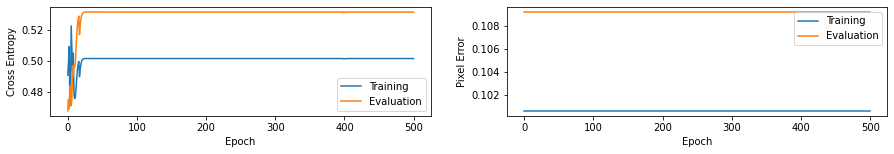

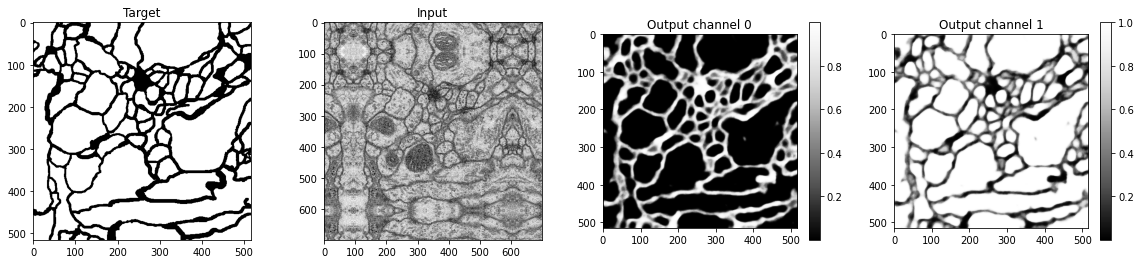

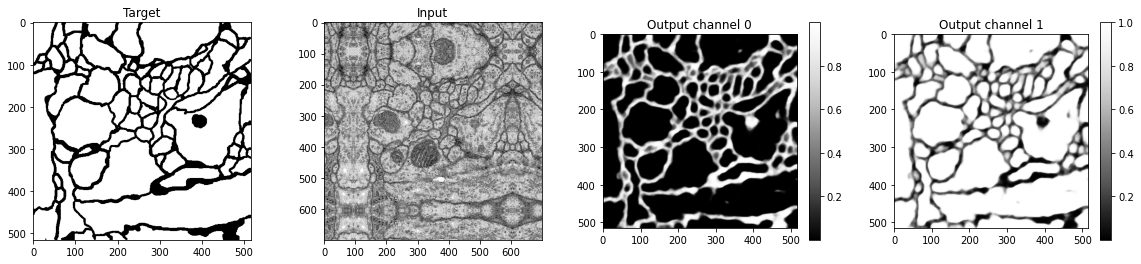

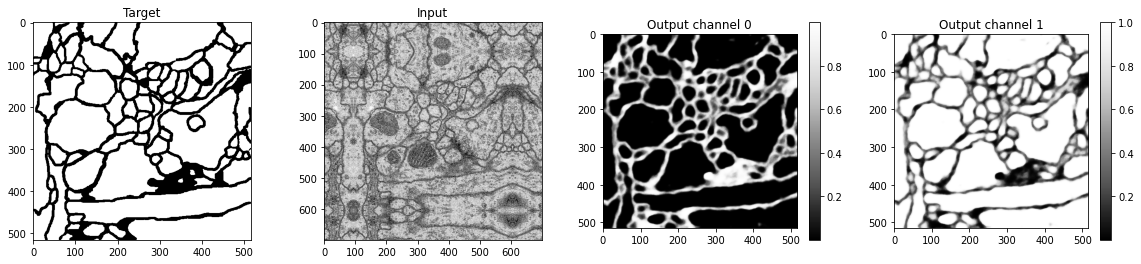

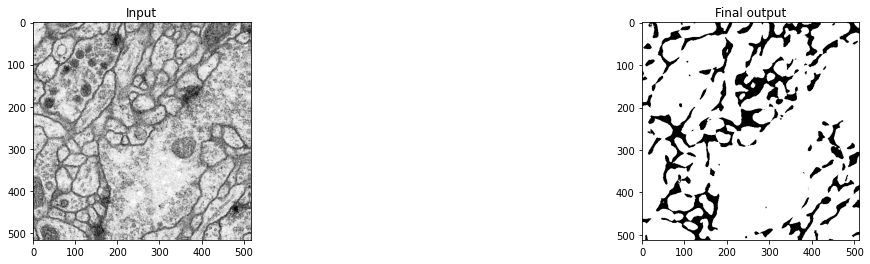

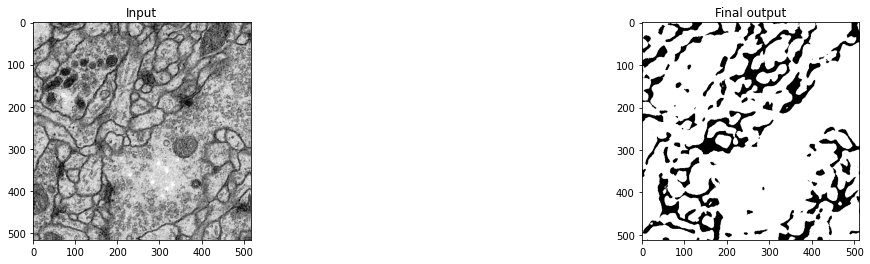

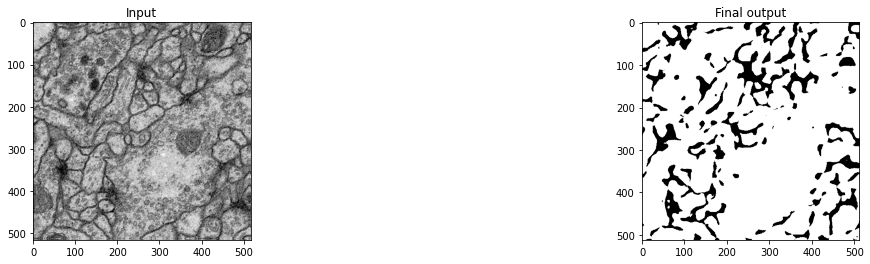

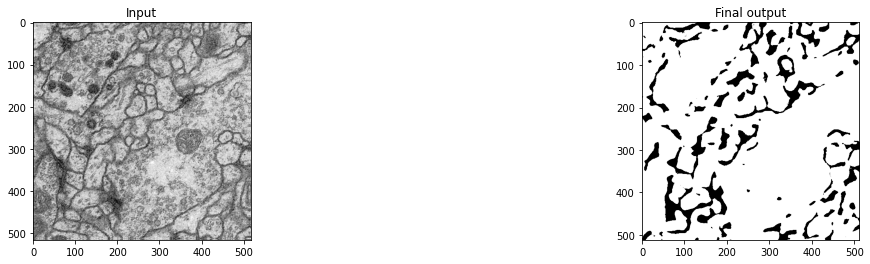

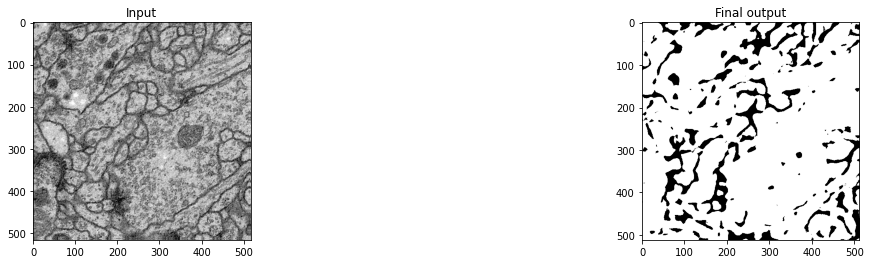

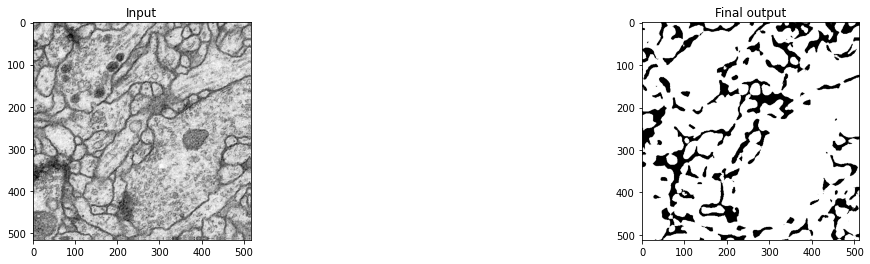

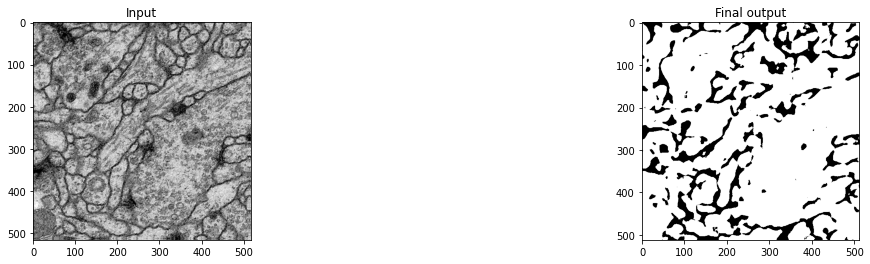

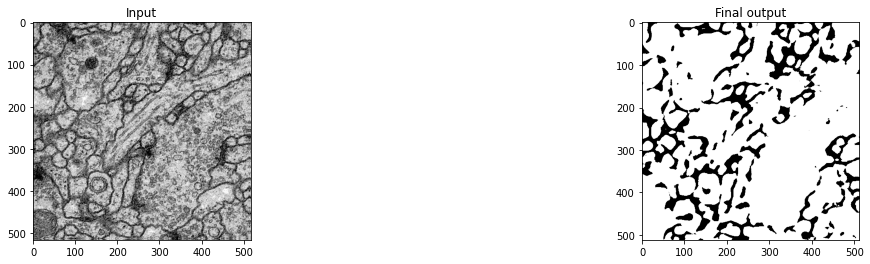

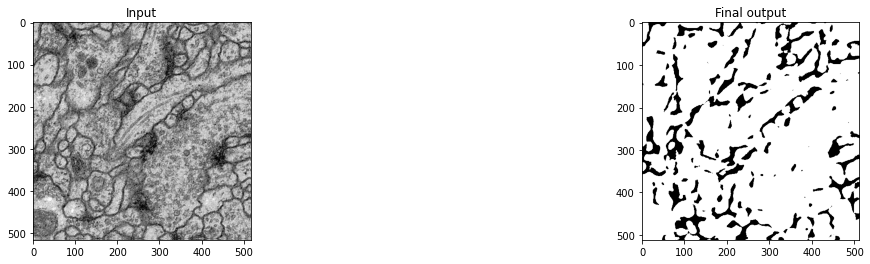

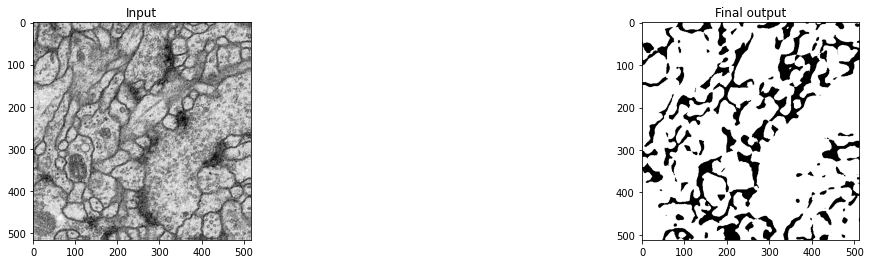

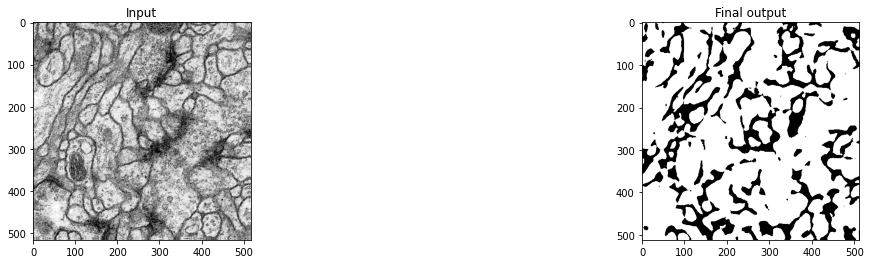

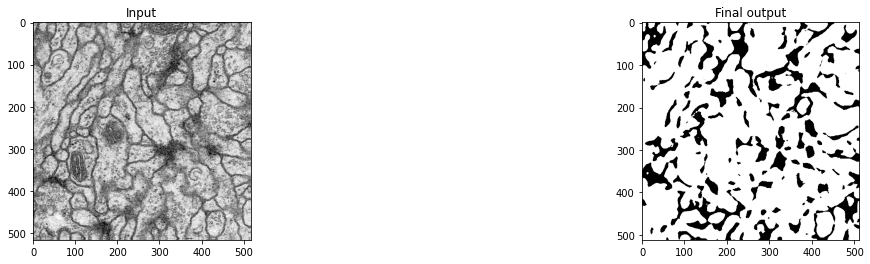

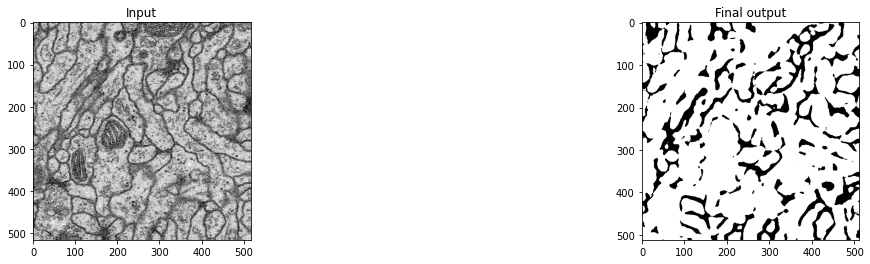

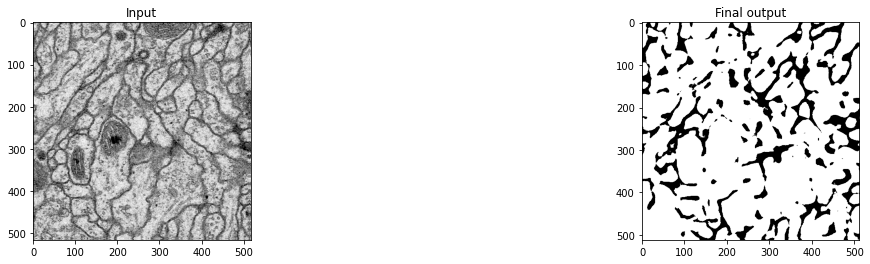

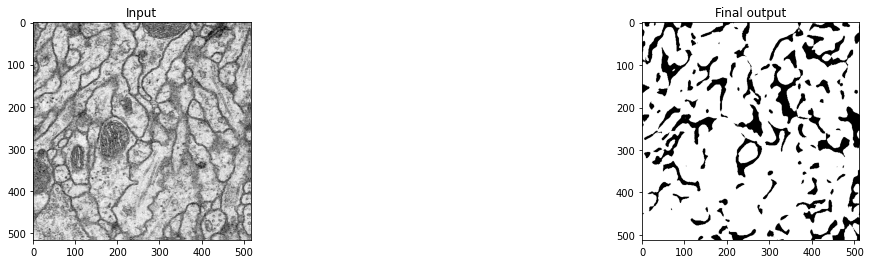

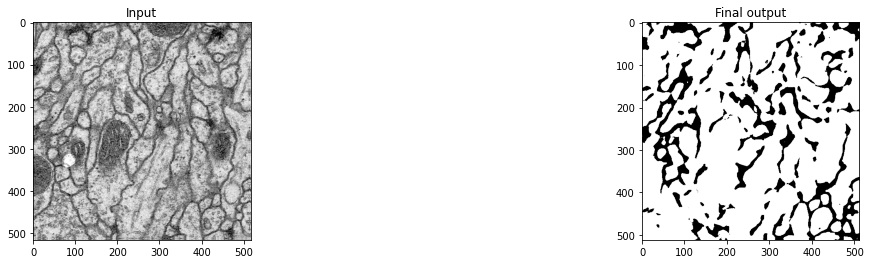

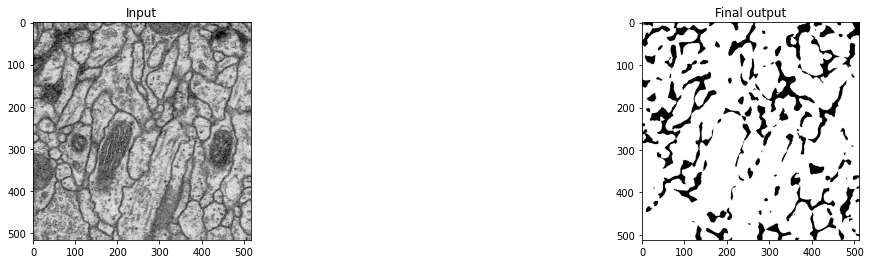

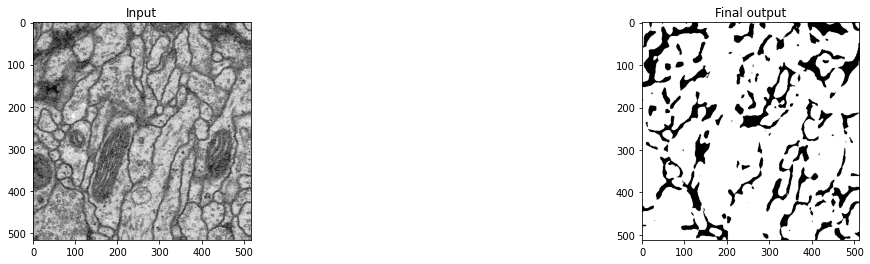

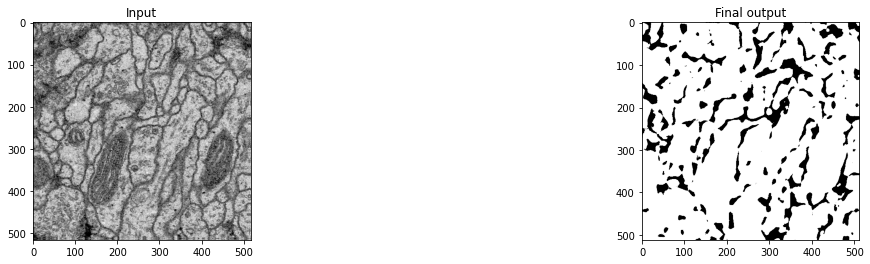

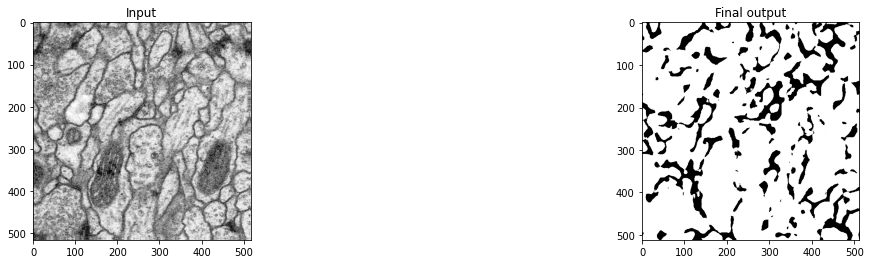

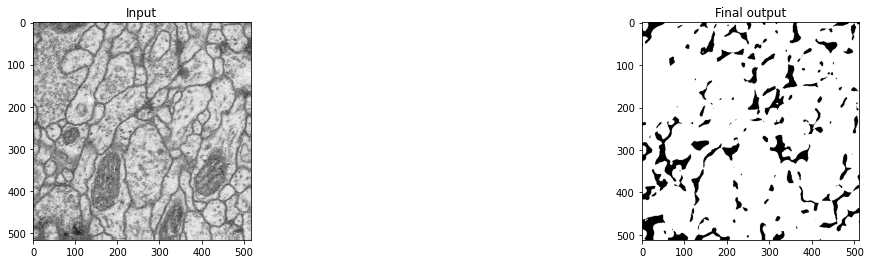

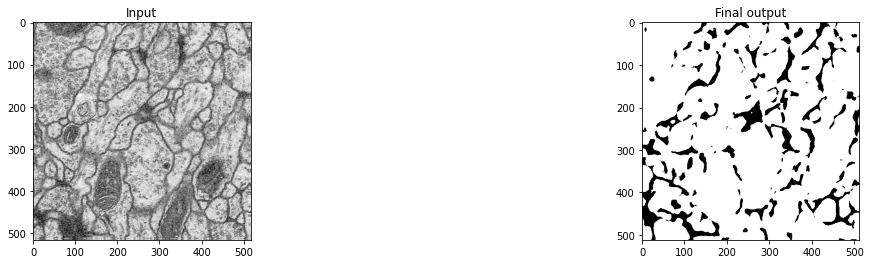

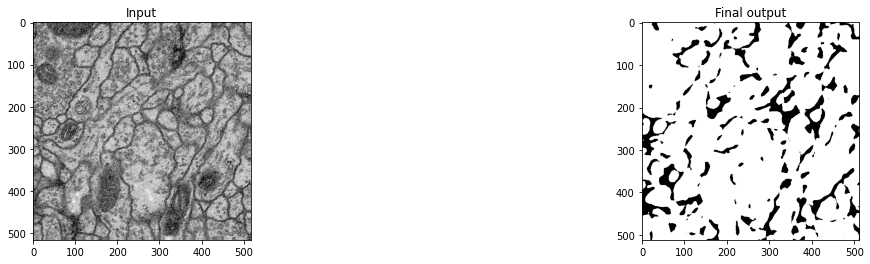

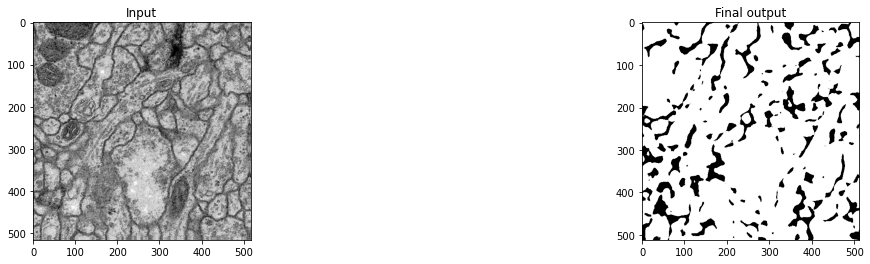

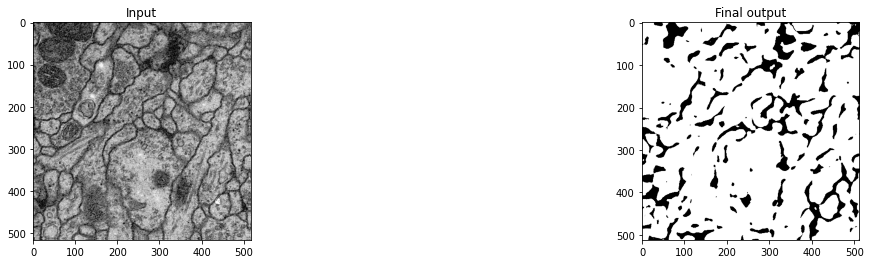

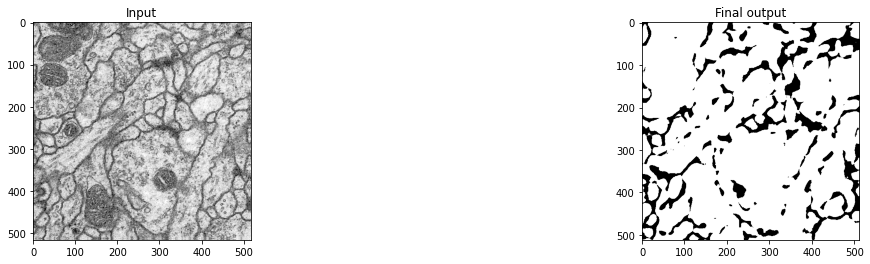

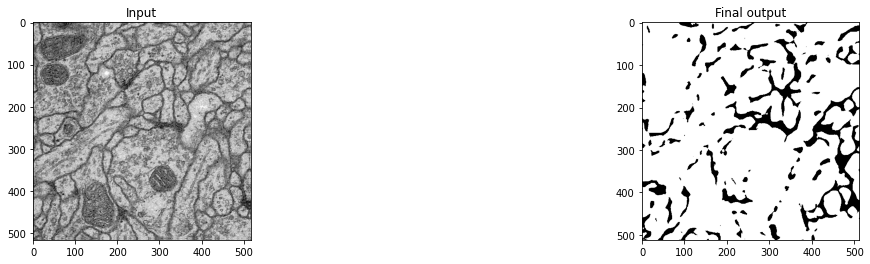

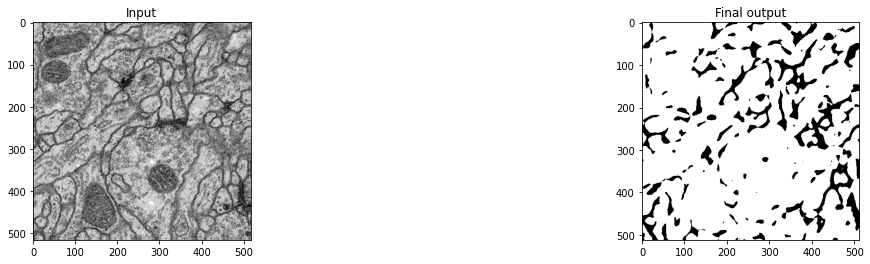

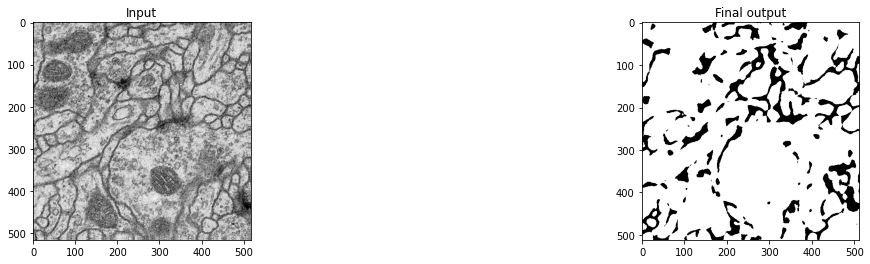

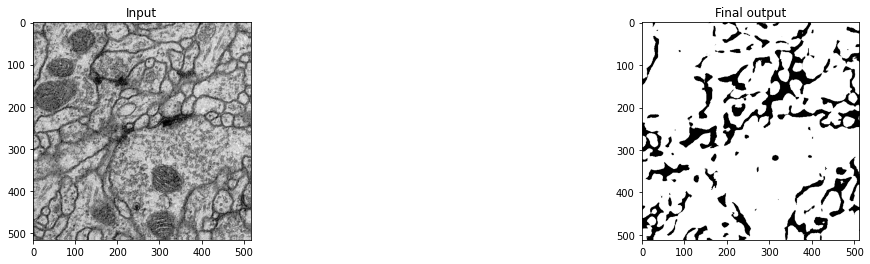

Main execution time: 11800.347588404999 seconds


In [33]:
import pickle # TODO Move import up
# Set flags
train = True    # If True, the model will be trained.
eval = True     # If True, the dataset will be split in a training and evaluation set.
test = True     # If True, predictions will be generated given a trained model.

# Set Hyperparameters
args = {'dim': [700, 516],
        'epochs': 501,
        'start_epoch':0,
        'lr':0.01,
        'momentum':0.99,
        'weight_decay':0,
        'save_every':50,
        'augment': 5
        }

# Load the data from experiment 1
SEG_train_loader, SEG_eval_loader, SEG_test_loader = load_dataset_1(
                                args['dim'], train=train, eval=eval, test=test)

def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
    model = u_net().to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.SGD(model.parameters(), args['lr'], momentum=args['momentum'], weight_decay=args['weight_decay'])


    if train and not eval:

        train_losses, train_pixel_error = [], []        
        SEG_train_augmented = data_augmentation(SEG_train_loader, dim=args['dim'], augment=args['augment'], plot=False)       

        # Perform training and loss computation
        for epoch in range(args['epochs']):
            print('Epoch {}'.format(epoch))

            e_loss, e_pixel_error = model._train(SEG_train_augmented, criterion, optimizer, device, plot=True)
            train_losses.append(e_loss.val)
            train_pixel_error.append(e_pixel_error.val)

            if epoch % args['save_every'] == 0 and epoch != 0:
                print('Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                        'Pixel Error {error.val:.3f} ({error.avg:.3f})'.format(
                        loss=e_loss, error=e_pixel_error))
                print("Saving")
                save_model(epoch, model.state_dict(), optimizer.state_dict())
        
        # Save errors to file
        pickle.dump(train_losses, open(r'Trained models/train_losses_lr_{}.p'.format(args['lr']), "wb"))
        pickle.dump(train_pixel_error, open(r'Trained models/train_pixel_lr_{}.p'.format(args['lr']), "wb"))

        # Plot results      
        fig= plt.figure(figsize=(15, 2))
        plt.subplot(1, 2, 1)
        plt.plot(train_losses)
        plt.xlabel('Epoch') 
        plt.ylabel('Training - Cross Entropy')
        plt.subplot(1, 2, 2)
        plt.plot(train_pixel_error)
        plt.xlabel('Epoch') 
        plt.ylabel('Training - Pixel Error')


    elif train and eval:
        print('Training and evaluation started')

        train_losses, train_pixel_error = [], []
        eval_losses, eval_pixel_error = [], []      

        SEG_train_augmented = data_augmentation(SEG_train_loader, dim=args['dim'], augment=args['augment'], plot=False) 
        print('Training set augmented')
        SEG_eval_augmented = data_augmentation(SEG_eval_loader, dim=args['dim'], augment=args['augment'], plot=False) 
        print('Evaluation set augmented')

        for epoch in range(args['epochs']):
            print('Epoch: {}'.format(epoch))
    
            et_loss, et_pixel_error = model._train(SEG_train_augmented, criterion, optimizer, device)   
            ee_loss, ee_pixel_error = model.evaluate(SEG_eval_augmented, criterion, device)
 
            # Saves losses and errors
            train_losses.append(et_loss.val)
            train_pixel_error.append(et_pixel_error.val)
            eval_losses.append(ee_loss.val)
            eval_pixel_error.append(ee_pixel_error.val)

            if epoch % args['save_every'] == 0 and epoch != 0:
                print('Epoch {epoch}\t Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                        'Pixel Error {error.val:.3f} ({error.avg:.3f})'.format(
                        epoch=epoch, loss=et_loss, error=et_pixel_error))
                print("Saving")
                save_model(epoch, model.state_dict(), optimizer.state_dict())


        # Save errors to file
        pickle.dump(train_losses, open(r'Trained models/train_losses_lr_{}.p'.format(args['lr']), "wb"))
        pickle.dump(train_pixel_error, open(r'Trained models/train_pixel_lr_{}.p'.format(args['lr']), "wb"))
        pickle.dump(eval_losses, open(r'Trained models/eval_losses_lr_{}.p'.format(args['lr']), "wb"))
        pickle.dump(eval_pixel_error, open(r'Trained models/eval_pixel_lr_{}.p'.format(args['lr']), "wb"))

        print('Training and evaluation completed')
        fig= plt.figure(figsize=(15, 2))
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Training')
        plt.plot(eval_losses, label='Evaluation')
        plt.legend()
        plt.xlabel('Epoch') 
        plt.ylabel('Cross Entropy')
        plt.subplot(1, 2, 2)
        plt.plot(train_pixel_error, label='Training')
        plt.plot(eval_pixel_error, label='Evaluation')
        plt.legend()
        plt.xlabel('Epoch') 
        plt.ylabel('Pixel Error')
        plt.show()


    if test:
        if torch.cuda.is_available():
            checkpoint = torch.load(r'Trained models/model, epoch:400.pth')
        else:
            checkpoint = torch.load(r'Trained models/model, epoch:400.pth', map_location=torch.device('cpu'))

        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
    
    # Plot channels and final output
    x = data_augmentation(SEG_train_loader, args['dim'], augment=0)
    model.evaluate(x[10:13], criterion, device, plot=True)

    # Plot test final output
    model.predict(SEG_test_loader)

tic = time.perf_counter()
main()
toc = time.perf_counter()
print("Main execution time: {} seconds".format(toc- tic))

# **Final results**

The best model we could find was obtained with a learning rate of 0.0001. We trained it with the full dataset. As can be seen in the graphs below, at epoch 900 the pixel error was below 3%. Based on visual inspection and to avoid overfitting, we submitted to the challenge the trained on 500 epochs.

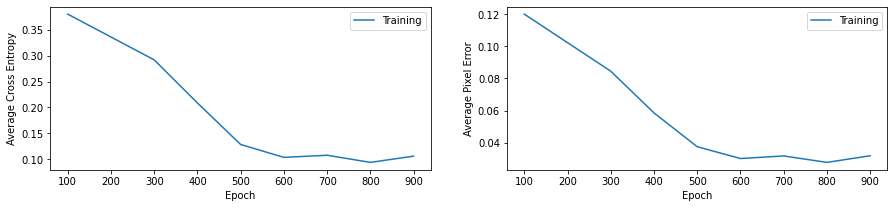

In [32]:
# Set flag
train = True
eval = False
test = True

# Set Hyperparameters
args = {'dim': [700, 516],
        'epochs': 1001,
        'start_epoch':0,
        'lr':0.001,
        'momentum':0.99,
        'weight_decay':0,
        'save_every':200,
        'augment': 0
        }

# Define trained models to evaluate
trained_models = list(range(100,1000,100))
del trained_models[1]

# Load the data from experiment 1
SEG_train_loader, SEG_eval_loader, SEG_test_loader = load_dataset_1(args['dim'], train=train, eval=eval, test=test)

# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
model = u_net().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), args['lr'], momentum=args['momentum'], weight_decay=args['weight_decay'])


if train and not eval:
    train_losses, train_pixel_error = [], []   
    SEG_train_augmented = data_augmentation(SEG_train_loader, args['dim'], augment=args['augment'])

    for epoch in trained_models:

        file = r'Trained models/model, epoch:{}.pth'.format(int(epoch))
        if torch.cuda.is_available():
            checkpoint = torch.load(file)
        else:
            checkpoint = torch.load(file, map_location=torch.device('cpu'))
        
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']

        et_loss, et_pixel_error = model.evaluate(SEG_train_augmented, criterion, device)   
        # print(et_pixel_error.val, et_pixel_error.avg)
        train_losses.append(et_loss.avg)
        train_pixel_error.append(et_pixel_error.avg)


if train and eval:
    train_losses, train_pixel_error = [], []
    eval_losses, eval_pixel_error = [], []   

    SEG_train_augmented = data_augmentation(SEG_train_loader, args['dim'], augment=args['augment'])
    SEG_eval_augmented = data_augmentation(SEG_eval_loader, args['dim'], augment=args['augment'])

    for epoch in trained_models:

        file = r'Trained models/model, epoch:{}.pth'.format(int(epoch))
        if torch.cuda.is_available():
            checkpoint = torch.load(file)
        else:
            checkpoint = torch.load(file, map_location=torch.device('cpu'))
        
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']

        et_loss, et_pixel_error = model.evaluate(SEG_train_augmented, criterion, device)   
        ee_loss, ee_pixel_error = model.evaluate(SEG_eval_augmented, criterion, device)
    
        # Saves losses and errors
        train_losses.append(et_loss.avg)
        train_pixel_error.append(et_pixel_error.avg)
        eval_losses.append(ee_loss.avg)
        eval_pixel_error.append(ee_pixel_error.avg)
       
# Plots
fig= plt.figure(figsize=(15, 3))
plt.subplot(1, 2, 1)
plt.plot(trained_models, train_losses, label='Training')
plt.legend()
plt.xlabel('Epoch') 
plt.ylabel('Average Cross Entropy')
plt.subplot(1, 2, 2)
plt.plot(trained_models, train_pixel_error, label='Training')
plt.legend()
plt.xlabel('Epoch') 
plt.ylabel('Average Pixel Error')

if eval:
    plt.subplot(1, 2, 1)
    plt.plot(trained_models, eval_losses, label='Evaluation')
    plt.legend()
    plt.xlabel('Epoch') 
    plt.ylabel('Average Cross Entropy')
    plt.subplot(1, 2, 2)
    plt.plot(trained_models, eval_pixel_error, label='Evaluation')
    plt.legend()
    plt.xlabel('Epoch') 
    plt.ylabel('Average Pixel Error')

plt.show()

# **Final score and veredict**


After generating our predictions, we want to compare them with the results from the original article. To be able to do so, we submited our predictions to the ISBI Segmentation challenge website (http://brainiac2.mit.edu/isbi_challenge/). 

However, in the time between the publication of the original article and our reproduction attempt, the metrics used by the challenge have changed. They used to return the Warping Error, Rand Error and Pixel Error but they changed over to Rand Score Thin and Information Score Thin. Thus, we are unable to compare our performance to the article's based on the original metrics. The challenge helpfully displays the new metrics also for older submissions, including the original article's. 

Below, we compare the errors found by the original article and ours. 

The errors presented by the original article:

|  | Warping Error | Rand Error | Pixel Error |
| --- | --- | --- | --- |
| *Human values* | 0.000005 | 0.0021 | 0.0010 |
| Original | 0.000353 | 0.0382 | 0.0611 |

The new metrics:

|  | Rand Score Thin | Information Score Thin | 
| --- | --- | --- | 
| *Human values* | 0.997847778 | 0.998997659 |
| Original | 0.972760748 | 0.986616590 | 
| Reproduction | 0.413889494| 0.659215557 |



From this, we can see that with both metrics we are not close to the results from the original article. 

This can be explained by both our relative inexperience in the field and the minimal details provided by the original article. 